In [37]:
# Setup Environment and Import Libraries
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix
)

In [38]:
# Data Loading and Preprocessing
csv_path = "../datasets/mobile_price_classification.csv"
target_column = "price_range"

# Load Data
df = pd.read_csv(csv_path)
print(f"Dataset Shape: {df.shape}")

# Encode Target if it is categorical (e.g., "Yes"/"No" -> 1/0)
le = LabelEncoder()
df[target_column] = le.fit_transform(df[target_column])

# Define X (Features) and y (Target)
X = df.drop(columns=[target_column])
y = df[target_column]

# One-Hot Encode Categorical Features
X = pd.get_dummies(X, drop_first=True)

# Train-Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save Test Set for future evaluation in datasets folder
test_set = pd.concat([X_test, y_test], axis=1)
test_set.to_csv("../datasets/test-data.csv", index=False)

# Save Tarin Set for future evaluation in datasets folder
train_set = pd.concat([X_train, y_train], axis=1)
train_set.to_csv("../datasets/train-data.csv", index=False)

# Scale Features (Crucial for KNN and Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Preprocessing Complete.")
print(f"Training features: {X_train.shape[1]}")

Dataset Shape: (2000, 21)
Data Preprocessing Complete.
Training features: 20


In [39]:
# Ensure the directory exists before saving (prevents FileNotFoundError)
import os
if not os.path.exists("../model"):
    os.makedirs("../model")

# Dictionary of models
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000), # Increased max_iter for safety
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbor": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss') # Parameter updated to fix warning
}

results = []

print("Training Models...")

for name, model in models.items():
    # specialized scaling for models that need it
    if name in ["Logistic Regression", "K-Nearest Neighbor"]:
        X_train_run = X_train_scaled
        X_test_run = X_test_scaled
    else:
        X_train_run = X_train
        X_test_run = X_test
        
    # Train
    model.fit(X_train_run, y_train)
    
    # Save the model to ../model directory
    filename = f"../model/{name.lower().replace(' ', '_')}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    
    # Predict
    y_pred = model.predict(X_test_run)
    
    # AUC Calculation (For Multi-class)
    try:
        # Get probabilities for ALL classes (removed [:, 1])
        y_prob = model.predict_proba(X_test_run)
        
        # Calculate Multi-class AUC (One-vs-Rest)
        auc = roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted')
    except Exception as e:
        print(f"AUC Warning for {name}: {e}")
        auc = 0.0

    # Collect Metrics
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": auc,
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "MCC": matthews_corrcoef(y_test, y_pred)
    }
    results.append(metrics)
    print(f"✔ {name} completed.")

Training Models...
✔ Logistic Regression completed.
✔ Decision Tree completed.
✔ K-Nearest Neighbor completed.
✔ Naive Bayes completed.
✔ Random Forest completed.
✔ XGBoost completed.



--- MODEL PERFORMANCE COMPARISON ---


,Model,Accuracy,AUC,Precision,Recall,F1 Score,MCC
0,Logistic Regression,0.9525,0.997506,0.952938,0.9525,0.952080,0.937094
1,Decision Tree,0.8100,0.873160,0.808716,0.8100,0.808639,0.747170
2,K-Nearest Neighbor,0.5100,0.756506,0.515997,0.5100,0.508986,0.348594
3,Naive Bayes,0.8175,0.954429,0.819398,0.8175,0.818276,0.756723
4,Random Forest,0.8550,0.976760,0.855333,0.8550,0.853413,0.807848
5,XGBoost,0.9225,0.988920,0.922650,0.9225,0.922563,0.896659


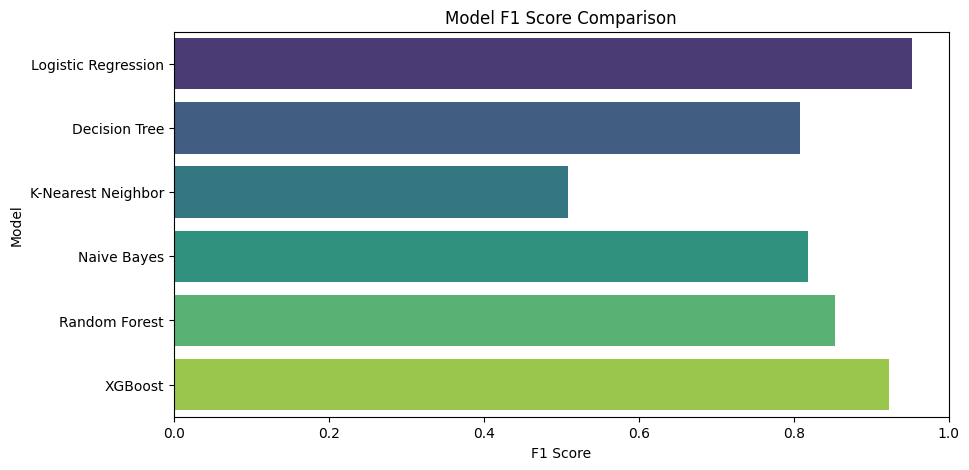

In [40]:
# Display Results and Evaluation
# Create DataFrame
results_df = pd.DataFrame(results)

# Display table
print("\n--- MODEL PERFORMANCE COMPARISON ---")
display(results_df)

# Visualize F1 Score Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x="F1 Score", y="Model", hue="Model", data=results_df, palette="viridis", legend=False)
plt.title("Model F1 Score Comparison")
plt.xlim(0, 1)
plt.show()